# Interaction Prediction

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 5A-G

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neteval.network_statistics import NetworkStats, load_network_names
from tqdm import tqdm
import os
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25


In [3]:
gitdir = os.path.expanduser('~/Git/Network_Evaluation_Tools/')
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
evaldir = os.path.join(gitdir, 'Data/example_outputs/')
datadir = os.path.join(gitdir, 'Data/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
example_names = load_network_names(os.path.join(gitdir, 'Data/example_network_names.txt'))

## Example Analysis

With DIP, PID2, and Wan

In [4]:
l3_dir = os.path.join(evaldir, 'L3/')

In [5]:
with open(os.path.join(datadir, 'example_prefix_file.txt')) as f:
    prefixes = f.read().splitlines()

In [6]:
cv_results = []
corum_results = []
panther_results = []
missing = []
for prefix in prefixes:
    for fold in range(1,11):
        try:
            df = pd.read_csv(l3_dir+prefix+'.fold' + str(fold)+"_L3_results.tsv", sep="\t")
            df['network'] = prefix
            df['fold'] = fold
            cv_results.append(df)
    
        except FileNotFoundError:
            missing.append([prefix, fold, 'cv'])
        try:
            df = pd.read_csv(l3_dir+prefix+'.fold' + str(fold)+"_L3_corum_results.tsv", sep="\t")
            
            df['network'] = prefix
            df['fold'] = fold
            corum_results.append(df)
        except FileNotFoundError:
            missing.append([prefix, fold, 'corun'])

        try:
            df = pd.read_csv(l3_dir+prefix+'.fold' + str(fold)+"_L3_panther_results.tsv", sep="\t")
            df['network'] = prefix
            df['fold'] = fold
            panther_results.append(df)
        except FileNotFoundError:
            missing.append([prefix, fold, 'panther'])
            
print('Succeeded: {}'.format(len(cv_results)+len(corum_results)+len(panther_results)))
print('Failed: {}'.format(len(missing)))
print('SELF:',len(cv_results) )
print('CORUM',len(corum_results))
print('PANTHER',len(panther_results))

Succeeded: 90
Failed: 0
SELF: 30
CORUM 30
PANTHER 30


In [7]:
def create_predictions_df(results_list, names, group=None):
    results_df = pd.concat(results_list).reset_index(drop=True)
    results_df['network'] = results_df.network.map(names)
    results_df['pAUPRC_ratio'] = results_df['AUPRC'] / results_df['baseAUPRC']
    if group is not None:
        results_df['Group'] = group
    return results_df

In [8]:
cv_l3_df = create_predictions_df(cv_results, example_names, 'CV')
corum_l3_df = create_predictions_df(corum_results, example_names, 'CORUM')
panther_l3_df = create_predictions_df(panther_results, example_names, 'PANTHER')

In [9]:
def compare_prediction_methods(l3_df, mps_df, metric, partial, net_order=None, plot_type='bar', ax=None, top_n=None, exclude_nets=None, palette=None,):
    l3_df.rename(columns={'baseAUPRC': 'baselineAUPRC'}, inplace=True)
    mps_df.rename(columns={'baseAUPRC': 'baselineAUPRC'}, inplace=True)
    l3_df['method'] = 'L3'
    mps_df['method'] = 'MPS'
    plot_df = pd.concat([l3_df, mps_df])
    plot_df = plot_df[plot_df.partial==partial]
    if exclude_nets is not None:
        plot_df = plot_df[~plot_df.network.isin(exclude_nets)]
    if net_order is None:
        net_order = plot_df.network.unique()[::-1]
    if type(net_order) == str:
        if net_order in plot_df.columns:
            net_order = plot_df.groupby('network')[net_order].mean().sort_values(ascending=False).index
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 8))
    
    if top_n is not None:
        plot_df = plot_df[plot_df['network'].isin(net_order[:top_n])]
        net_order=net_order[:top_n]
    if plot_type=='strip':
        plot_df = plot_df.reset_index(drop=True)
        sns.stripplot(data = plot_df[plot_df.partial==partial], y='network', x=metric, ax=ax, hue='method', dodge=False, s=3, 
                      order=net_order, jitter=False, edgecolor='black', linewidth=0.25, alpha=0.5,  hue_order=['MPS', 'L3'], palette=palette)
        sns.pointplot(data = plot_df[plot_df.partial==partial], y='network', x=metric, ax=ax, hue='method', dodge=False,
                      order=net_order, linestyle='none', errorbar=None, marker='|', markersize=6,  hue_order=['MPS', 'L3'],palette=palette)
        # add horizontal lines between y ticks
        for i in range(len(net_order)):
            ax.hlines(i+0.5, 0, 1, color='grey', linewidth=0.25)
    elif plot_type == 'bar':
        plot_df = plot_df.reset_index(drop=True)
        sns.barplot(data=plot_df, y='network', x=metric, ax=ax, hue='method', order=net_order, hue_order=['MPS', 'L3'], alpha=0.6, errorbar=None, edgecolor='black', 
                    linewidth=0.25, palette=palette, saturation=1)
        if metric=='AUPRC':
            sns.barplot(data=plot_df, y='network', x='baselineAUPRC', ax=ax, hue='method', palette=['grey', 'grey'], order=net_order, alpha=0.5)
        ax.set_xscale('log')
    #plot_metric(plot_df[plot_df.partial==partial], metric=metric, net_order=metric,hue='method', ax=ax1, dodge=True)
    #plot_metric(df2[df2.partial==partial], metric=metric, net_order=metric, ax=ax2)
    return net_order

In [10]:
cv_l3_df

,partial,baseAUPRC,AUPRC,P@k,network,fold,pAUPRC_ratio,Group
0,p@500,0.000024,0.012407,0.158000,DIP,1,522.571670,CV
1,p@test,0.000044,0.022217,0.144118,DIP,1,502.874462,CV
2,p@1%,0.000005,0.002288,0.173469,DIP,1,447.876650,CV
3,p@500,0.000028,0.018780,0.182000,DIP,2,673.420698,CV
4,p@test,0.000049,0.030625,0.157380,DIP,2,620.692348,CV
...,...,...,...,...,...,...,...,...
85,p@test,0.000006,0.001552,0.019765,Wan,9,242.647154,CV
86,p@1%,0.000003,0.001077,0.116438,Wan,9,316.804199,CV
87,p@500,0.000005,0.001441,0.046000,Wan,10,316.062913,CV
88,p@test,0.000007,0.001672,0.021645,Wan,10,241.103737,CV


<AxesSubplot:xlabel='P@k', ylabel='network'>

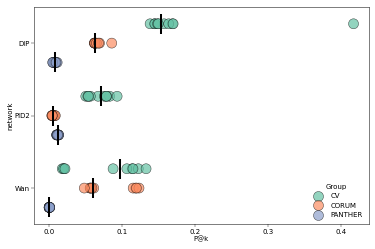

In [11]:
plot_df  = pd.concat([cv_l3_df, corum_l3_df, panther_l3_df])
sns.stripplot(plot_df[plot_df.partial=='p@test'], x = 'P@k', y='network', hue='Group', dodge=0.5, s=10, jitter=False, edgecolor='black', linewidth=0.5, alpha=0.7, 
                hue_order=['CV', 'CORUM', 'PANTHER'], palette='Set2', zorder=1)
sns.pointplot(data = plot_df[plot_df.partial=='p@test'], y='network', x='P@k', hue='Group', dodge=0.53, estimator='median',
                linestyle='none', errorbar=None, marker='|', markersize=20,  hue_order=['CV', 'CORUM', 'PANTHER'],palette=['black', 'black', 'black'], zorder=3, legend=False)

## Figures 5A-C - Interaction Prediction Precision

Load the prediction results from Supplemental Table 4

In [12]:
pred_results = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/TableS4.txt'), sep='\t')

In [13]:
pred_results.columns = ['network', 'fold', 'method', 'Test Set', 'P@k']

In [14]:
def compare_prediction_methods(plot_df, metric, test_set, net_order=None, plot_type='strip', ax=None, top_n=None, exclude_nets=None, palette=None,):
    #l3_df.rename(columns={'baseAUPRC': 'baselineAUPRC'}, inplace=True)
    #mps_df.rename(columns={'baseAUPRC': 'baselineAUPRC'}, inplace=True)
    #l3_df['method'] = 'L3'
    #mps_df['method'] = 'MPS'
    plot_df = plot_df[plot_df['Test Set']==test_set]
    if exclude_nets is not None:
        plot_df = plot_df[~plot_df.network.isin(exclude_nets)]
    if net_order is None:
        net_order = plot_df.network.unique()[::-1]
    if type(net_order) == str:
        if net_order in plot_df.columns:
            net_order = plot_df.groupby('network')[net_order].mean().sort_values(ascending=False).index
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 8))
    
    if top_n is not None:
        plot_df = plot_df[plot_df['network'].isin(net_order[:top_n])]
        net_order=net_order[:top_n]
    if plot_type=='strip':
        plot_df = plot_df.reset_index(drop=True)
        sns.stripplot(data = plot_df, y='network', x=metric, ax=ax, hue='method', dodge=False, s=3, 
                      order=net_order, jitter=False, edgecolor='black', linewidth=0.25, alpha=0.5,  hue_order=['MPS', 'L3'], palette=palette)
        sns.pointplot(data = plot_df, y='network', x=metric, ax=ax, hue='method', dodge=False,
                      order=net_order, linestyle='none', errorbar=None, marker='|', markersize=6,  hue_order=['MPS', 'L3'],palette=palette, legend=False)
        # add horizontal lines between y ticks
        for i in range(len(net_order)):
            ax.hlines(i+0.5, 0, 1, color='grey', linewidth=0.25)
    elif plot_type == 'bar':
        plot_df = plot_df.reset_index(drop=True)
        sns.barplot(data=plot_df, y='network', x=metric, ax=ax, hue='method', order=net_order, hue_order=['MPS', 'L3'], alpha=0.6, errorbar=None, edgecolor='black', 
                    linewidth=0.25, palette=palette, saturation=1)
        if metric=='AUPRC':
            sns.barplot(data=plot_df, y='network', x='baselineAUPRC', ax=ax, hue='method', palette=['grey', 'grey'], order=net_order, alpha=0.5)
        ax.set_xscale('log')
    #plot_metric(plot_df[plot_df.partial==partial], metric=metric, net_order=metric,hue='method', ax=ax1, dodge=True)
    #plot_metric(df2[df2.partial==partial], metric=metric, net_order=metric, ax=ax2)
    return net_order

/tmp/ipykernel_2518907/105141934.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(os.path.join(figdir, 'Fig5ABC_prediciton_results.jpg'), dpi=300, bbox_inches='tight')
/tmp/ipykernel_2518907/105141934.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(os.path.join(figdir, 'Fig5ABC_prediciton_results.jpg'), dpi=300, bbox_inches='tight')
/tmp/ipykernel_2518907/105141934.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(os.path.join(figdir, 'Fig5ABC_prediciton_results.jpg'), dpi=300, bbox_inches='tight')
/tmp/ip

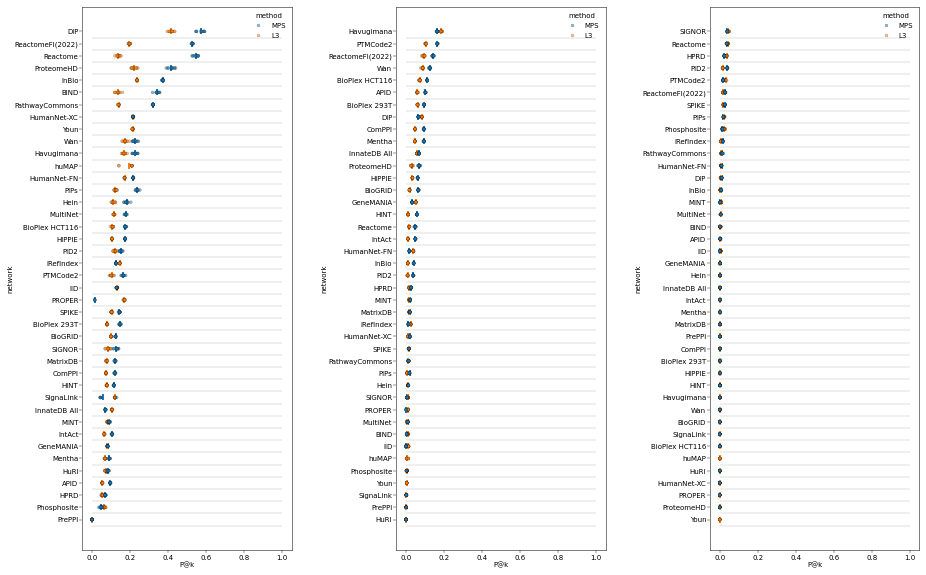

In [15]:
_, [ax1, ax2, ax3] = plt.subplots(ncols=3, nrows=1, figsize=(15, 10), gridspec_kw={'wspace': 0.5})
compare_prediction_methods(pred_results, 'P@k', test_set='Held-out', net_order='P@k', ax=ax1)
compare_prediction_methods(pred_results, 'P@k', test_set='CORUM', net_order='P@k', ax=ax2)
compare_prediction_methods(pred_results, 'P@k', test_set='PANTHER', net_order='P@k', ax=ax3)
plt.savefig(os.path.join(figdir, 'Fig5ABC_prediciton_results.jpg'), dpi=300, bbox_inches='tight')

## Figure 5D - Network Coverage of Predicted Interactions

In [16]:
coverage_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig5D_interaction_coverage.csv'))

In [17]:
def plot_coverage_stats(coverage_df, ax=None, order=None, **kwargs):
    coverage_stats =coverage_df.drop_duplicates(subset=['network', 'fold']).dropna().set_index('Name')
    stack_data = coverage_stats.groupby(['Name']).mean().loc[:, ('0-1', '2-5', '6-10', '11-20', '21+')]
    return_order=False
    if order is None:
        order=list(stack_data.sort_values(by=['21+', '11-20', '6-10', '2-5', '0-1'], ascending=False).index)
        return_order=True
    if ax is None:
        _ = plt.figure(figsize=(10, 2))
        ax= plt.gca()
    stack_data.loc[order].plot(kind='bar', stacked=True, edgecolor='black', ax=ax, color=['#b8de29', '#73d055', '#29af7f', '#238a8d', '#33638d'][::-1], **kwargs)
    if return_order:
        return order

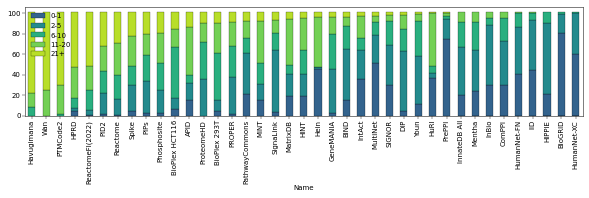

In [18]:
_ = plot_coverage_stats(coverage_df[coverage_df.method=='L3'])

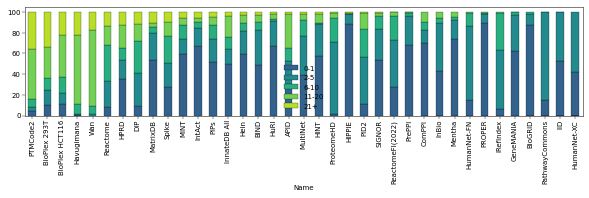

In [19]:
_ = plot_coverage_stats(coverage_df[coverage_df.method=='MPS'])

## Figure 5E - Network Coverage vs AF ipTM

Load the AlphaFold results

In [20]:
af_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/TableS5.txt'), sep='\t')

In [21]:
coverage_df = af_df[af_df['Analysis Set'] == 'Network Coverage']

Select the top model for each protein pair based on model confidence

In [22]:
coverage_df_top = coverage_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['NCBI Gene ID A', 'NCBI Gene ID B'], keep='first')

In [23]:
coverage_df_top['Pair_str'] = coverage_df_top['NCBI Gene ID A'].astype(str) + '-' + coverage_df_top['NCBI Gene ID B'].astype(str)

In [24]:
coverage_df_top['Network/Network Coverage'] = coverage_df_top['Network/Network Coverage'].astype(int)

Visualize the ipTM scores vs network coverage

Text(0, 0.5, 'Interface Score (IPTM)')

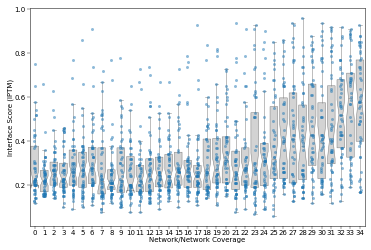

In [25]:
ax = plt.gca()
sns.stripplot(coverage_df_top.groupby('Pair_str').mean(), x='Network/Network Coverage', y='ipTM', ax=ax, size=3, alpha=0.5)
sns.boxplot(coverage_df_top.groupby('Pair_str').mean(), x='Network/Network Coverage', y='ipTM', ax=ax, fliersize=0, linewidth=0.5, notch=True, fill=True, color='lightgrey')
plt.xticks([i for i in range(35)], labels=[i for i in range(35)])

plt.ylabel('Interface Score (IPTM)')

### Figure 5E

In [26]:
coverage_df_top['Edge_Bin'] = coverage_df_top['Network/Network Coverage'].apply(lambda x: (x+3)//4)

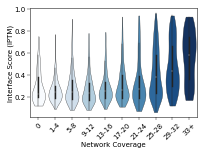

In [27]:
_ = plt.figure(figsize=(3, 2))
ax = plt.gca()
sns.violinplot(coverage_df_top, x='Edge_Bin', y='ipTM', ax=ax, cut=0, hue='Edge_Bin', palette='Blues', legend=False)
_ = plt.xticks([i for i in range(10)], labels=[0, '1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28', '29-32', '33+'], rotation=45)
plt.ylabel('Interface Score (IPTM)')
plt.xlabel('Network Coverage')

plt.savefig(figdir + 'Fig5E_ipTM_vs_coverage.jpg', bbox_inches='tight', dpi=300)

## Figure 5F - ipTM of sample network interactions

In [28]:
af_df['Analysis Set'].unique()

array(['Validation', 'Network Coverage', 'Network Specific'], dtype=object)

In [29]:
network_df = af_df[af_df['Analysis Set'] == 'Network Specific']
network_df.head()

,Network/Network Coverage,NCBI Gene ID A,NCBI Gene ID B,Analysis Set,Model Number,pTM,ipTM,Model Confidence
11155,APID,117144,2139,Network Specific,0,0.28,0.17,0.192
11156,APID,117144,2139,Network Specific,1,0.28,0.26,0.264
11157,APID,117144,2139,Network Specific,2,0.26,0.15,0.172
11158,APID,117144,2139,Network Specific,3,0.28,0.15,0.176
11159,APID,117144,2139,Network Specific,4,0.27,0.19,0.206


In [30]:
network_df_top = network_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['NCBI Gene ID A', 'NCBI Gene ID B'], keep='first')

In [32]:
rn_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig5_Random_AF_results.csv'), index_col=0)

In [33]:
mu_results = {}
for net in network_df['Network/Network Coverage'].unique():
    mu_rn = mannwhitneyu(network_df_top[network_df_top['Network/Network Coverage'] == net].ipTM, rn_df[rn_df.Background=='All random'].iptm).pvalue
    mu_zero = mannwhitneyu(network_df_top[network_df_top['Network/Network Coverage'] == net].ipTM, rn_df[rn_df.Background=='No edges random'].iptm).pvalue
    mu_results[net] = {'rn': mu_rn, 'zero': mu_zero}
mu_df = pd.DataFrame.from_dict(mu_results, orient='index')
mu_df['fdr_rn'] = fdrcorrection(mu_df['rn'])[1]
mu_df['fdr_zero'] = fdrcorrection(mu_df['zero'])[1]

In [35]:
top_nets = list(mu_df[mu_df.fdr_rn < 0.15].index)


In [37]:
plot_data =network_df_top[network_df_top['Network/Network Coverage'].isin(top_nets)]

In [43]:
net_colors = {'Reactome':'Curated', 'ProteomeHD':'Experimental', 'DIP':'Curated', 'PID2':'Integrated', 'HPRD':'Curated', 'Spike':'Integrated',
            'PTMCode2':'Integrated', 'SIGNOR':'Curated', 'PROPER':'Experimental', 'BIND':'Curated', 'FunCoup':'Integrated'}

plot_data = plot_data.assign(color= plot_data['Network/Network Coverage'].map(net_colors))

In [40]:
order =plot_data.groupby('Network/Network Coverage').ipTM.median().sort_values(ascending=False).index

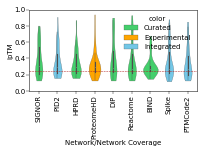

In [41]:
_ = plt.figure(figsize=(3,1.5))
sns.violinplot(data=plot_data, x='Network/Network Coverage', y='ipTM', cut=0, linewidth=0.25, hue='color', palette=['#44cf6c', '#ffa500', '#73c7e7'], 
                saturation=1, order=order)#, cut=0, inner='', fill=True)
plt.hlines(rn_df.iptm.median(), -0.5, 8.5, color='firebrick', linestyle='--', linewidth=0.5)
plt.ylim(0, 1)
plt.xlim(-0.5, 8.5)
ax  = plt.gca()
ax.tick_params(axis='x', rotation=90)
plt.savefig(figdir + 'Fig5F_Network_ipTM.jpg', bbox_inches='tight', dpi=300)

## Figure 5G - ipTM of potentially novel predicted interactions

In [45]:
validation_df = af_df[af_df['Analysis Set'] == 'Validation']
validation_df.head()

,Network/Network Coverage,NCBI Gene ID A,NCBI Gene ID B,Analysis Set,Model Number,pTM,ipTM,Model Confidence
0,Havugimana,55699,112464,Validation,0,0.73,0.18,0.290
1,Havugimana,55699,112464,Validation,1,0.74,0.20,0.308
2,Havugimana,55699,112464,Validation,2,0.72,0.22,0.320
3,Havugimana,55699,112464,Validation,3,0.73,0.19,0.298
4,Havugimana,55699,112464,Validation,4,0.73,0.22,0.322


In [69]:
validation_df_top = validation_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['NCBI Gene ID A', 'NCBI Gene ID B'], keep='first')

In [81]:
plot_nets = ['SIGNOR', 'PID2', 'HPRD', 'ProteomeHD', 'DIP', 'Reactome', 'Spike', 'PTMCode2', 'BIND']

In [82]:
validation_df_top = validation_df_top[validation_df_top['Network/Network Coverage'].isin(plot_nets)]

 Set validation threshold

Set Validation Threshold

In [83]:
iptm_th = rn_df.sort_values('model_conf', ascending=False).drop_duplicates(subset=['Pair_str'], keep='first').iptm.describe(percentiles=[0.95])['95%']
print('ipTM threshold:', iptm_th)  

ipTM threshold: 0.53


In [84]:
validation_df_top = validation_df_top.assign(Validated = validation_df_top.ipTM > iptm_th)

In [85]:
print('Overall validation rate:', validation_df_top.Validated.mean())

Overall validation rate: 0.23416506717850288


In [86]:
print('Network validation rates:')
validation_df_top.groupby('Network/Network Coverage').Validated.mean().sort_values(ascending=False)

Network validation rates:


Network/Network Coverage
SIGNOR        0.724138
Spike         0.192308
Reactome      0.178571
PID2          0.075000
HPRD          0.067308
DIP           0.062500
BIND          0.012500
PTMCode2      0.000000
ProteomeHD    0.000000
Name: Validated, dtype: float64

/tmp/ipykernel_2518907/1454426454.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(figdir + 'Fig5G_iptm_validation.jpg', bbox_inches='tight', dpi=300)
/tmp/ipykernel_2518907/1454426454.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig(figdir + 'Fig5G_iptm_validation.jpg', bbox_inches='tight', dpi=300)


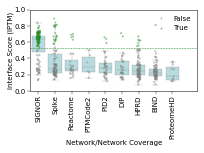

In [89]:
_ = plt.figure(figsize=(3,1.5))
order = validation_df_top.groupby('Network/Network Coverage').ipTM.mean().sort_values(ascending=False).index
sns.stripplot(data=validation_df_top, x='Network/Network Coverage', y='ipTM', s=2, alpha=0.5, hue='Validated', palette=['forestgreen', 'grey'][::-1], order=order)
sns.boxplot(data=validation_df_top, x='Network/Network Coverage', y='ipTM', fliersize=0, linecolor='grey', color='powderblue', linewidth=0.25)
plt.hlines(iptm_th, -0.5, 10.5, color='forestgreen', linestyle='--', linewidth=0.5)
plt.ylim(0,1)
plt.xlim(-0.5, 9.5)
plt.ylabel('Interface Score (IPTM)')
plt.gca().tick_params(axis='x', rotation=90)
plt.savefig(figdir + 'Fig5G_iptm_validation.jpg', bbox_inches='tight', dpi=300)

Statistics

In [92]:
rn_df_top = rn_df.sort_values('model_conf', ascending=False).drop_duplicates(subset=['Pair_str'], keep='first')

In [106]:
# need to do a mann whitney u test for each network against the random pairs
mu_results = {}
for net in validation_df_top['Network/Network Coverage'].unique():
    mu_rn = mannwhitneyu(validation_df_top[validation_df_top['Network/Network Coverage'] == net].ipTM, rn_df_top[rn_df_top.Background=='All random'].iptm).pvalue
    mu_results[net] = {'p': mu_rn}
mu_df = pd.DataFrame.from_dict(mu_results, orient='index')
mu_df['q'] = fdrcorrection(mu_df['p'])[1]




In [107]:
mu_df.sort_values('q')

,p,q
SIGNOR,6.552765e-42,5.897488e-41
Spike,3.375160e-06,1.518822e-05
Reactome,6.995813e-03,2.098744e-02
BIND,6.562101e-02,1.383332e-01
PID2,7.685180e-02,1.383332e-01
ProteomeHD,1.349968e-01,2.024951e-01
PTMCode2,2.861919e-01,3.679610e-01
DIP,3.847262e-01,4.328169e-01
HPRD,6.037011e-01,6.037011e-01
